In [18]:
import pandas as pd
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import geopandas as gpd
from matplotlib.lines import Line2D
from shapely.geometry import LineString

In [19]:
nodes_path = "/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/nodes_small_grid_num.csv"
edges_path = "/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/edges_small_grid_num.csv"

In [26]:
nodes = pd.read_csv(nodes_path, dtype={"node": int})
edges = pd.read_csv(edges_path, dtype={"node1": int, "node2": int})

G = nx.Graph()

for _, row in nodes.iterrows():
    G.add_node(int(row["node"]), x=int(row["x"]), y=int(row["y"]), z=int(row["z"]), type=row["type"])

for _, row in edges.iterrows():
    G.add_edge(
        int(row["node1"]),
        int(row["node2"]),
        type_car=row["type_car"],
        type_bike=row["type_bike"],
        speed=int(row["speed"]),
        lanes=int(row["lanes"])
    )

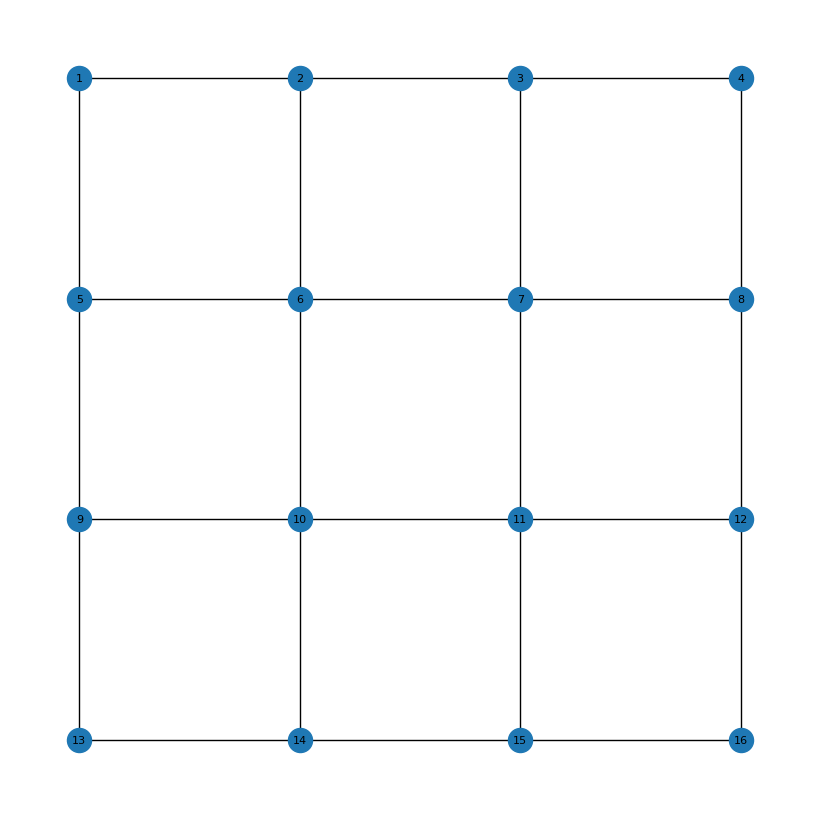

In [27]:
# NetworkX doesn't have a `plot` function. Use `draw` with matplotlib instead.
pos = {n: (d["x"], d["y"]) for n, d in G.nodes(data=True)}
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, with_labels=True, node_size=300, font_size=8)
plt.axis("equal")
plt.show()

In [28]:
# Ajout de l'attribut "lenght" (distance euclidienne 2D) aux arêtes

# Préparer les coordonnées des nœuds
_node_xy = nodes.set_index("node")[["x", "y"]]

# Calcul vectorisé des longueurs
edges["length"] = np.sqrt(
    (_node_xy.loc[edges["node1"], "x"].values - _node_xy.loc[edges["node2"], "x"].values) ** 2 +
    (_node_xy.loc[edges["node1"], "y"].values - _node_xy.loc[edges["node2"], "y"].values) ** 2
)

# Injection dans le graphe NetworkX
for _, r in edges.iterrows():
    G[r.node1][r.node2]["length"] = r["length"]

In [29]:
for edge in G.edges(data=True):
    if edge[2].get("type_bike") in ['bike_lane','bike_path']:
        edge[2]["bikes"] = True
    else:
        edge[2]["bikes"] = False

In [30]:
# Export du graphe G en fichier GraphML
nx.write_graphml(G, "/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/small_grid_graph.graphml")

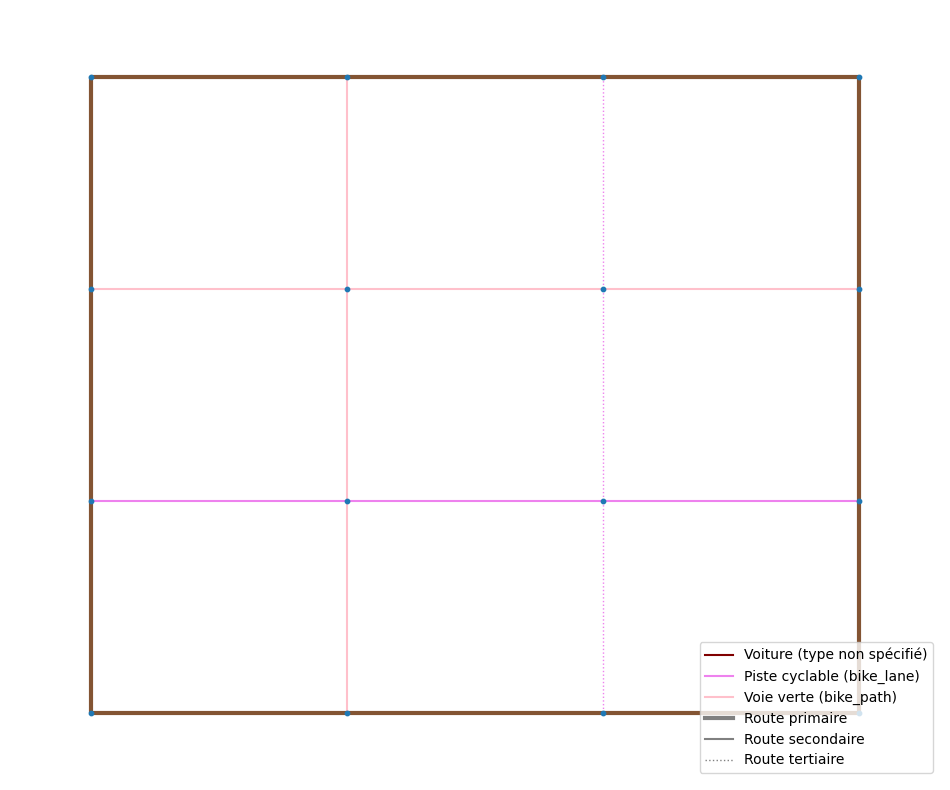

In [31]:
pos_big_city = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

edge_colors = []
edge_linewidths = []
edge_linestyles = []

# Définition des styles
color_map = {'bike_lane': 'violet', 'bike_path': 'pink'}
linewidth_map = {'primary': 3, 'secondary': 1.5, 'tertiary': 1}
linestyle_map = {'primary': 'solid', 'secondary': 'solid', 'tertiary': 'dotted'}

# Valeurs par défaut si un attribut est manquant
default_color = "#835433"
default_linewidth = 0.5
default_linestyle = 'solid'

for _, _, edge in G.edges(data=True):
    # Détermination de la couleur en fonction de 'type_bike'
    bike_type = edge.get('type_bike')
    edge_colors.append(color_map.get(bike_type, default_color))

    # Détermination de l'épaisseur et du style en fonction de 'type_car'
    car_type = edge.get('type_car')
    edge_linewidths.append(linewidth_map.get(car_type, default_linewidth))
    edge_linestyles.append(linestyle_map.get(car_type, default_linestyle))

fig, ax = plt.subplots(figsize=(12, 10))
# Affichage du graphe avec les styles personnalisés
nx.draw(
    G, pos_big_city,
    edge_color=edge_colors,
    width=edge_linewidths,
    style=edge_linestyles,
    node_size=10, ax=ax
)


legend_elements = [
    Line2D([0], [0], color='maroon', lw=1.5, label='Voiture (type non spécifié)'),
    Line2D([0], [0], color='violet', lw=1.5, label='Piste cyclable (bike_lane)'),
    Line2D([0], [0], color='pink', lw=1.5, label='Voie verte (bike_path)'),
    Line2D([0], [0], color='gray', lw=3, linestyle='solid', label='Route primaire'),
    Line2D([0], [0], color='gray', lw=1.5, linestyle='solid', label='Route secondaire'),
    Line2D([0], [0], color='gray', lw=1, linestyle='dotted', label='Route tertiaire')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.show()

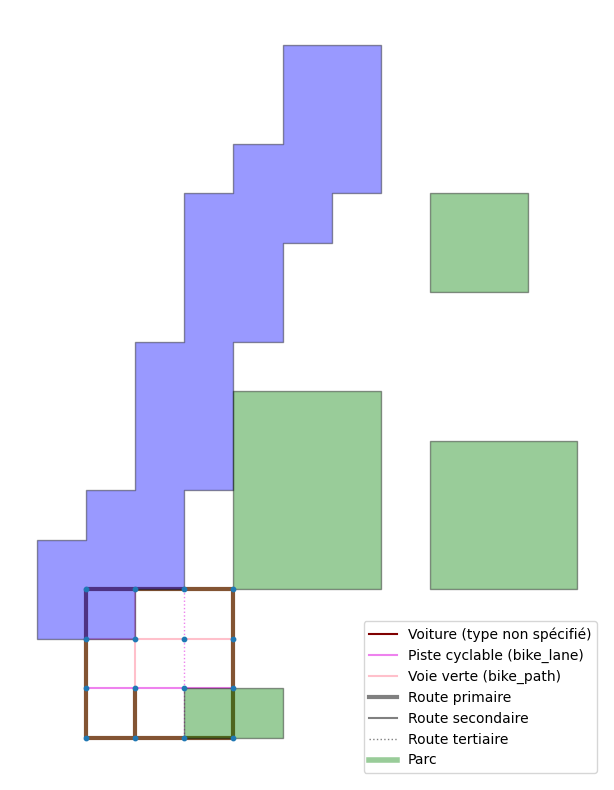

In [10]:
# Charger le fichier GeoJSON
parcs = gpd.read_file("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/parc_big_city.geojson")

# Recréer la figure pour y ajouter les parcs
fig, ax = plt.subplots(figsize=(12, 10))

# Redessiner le graphe
nx.draw(
    G, pos_big_city,
    edge_color=edge_colors,
    width=edge_linewidths,
    style=edge_linestyles,
    node_size=10, ax=ax
)

# Dessiner les polygones des parcs sur le même axe
parcs.plot(ax=ax, color=parcs['color'], alpha=0.4, edgecolor='black')

# Ajouter la légende (y compris pour les parcs)
legend_elements_with_parcs = legend_elements + [
    Line2D([0], [0], color="green", lw=4, alpha=0.4, label='Parc')
]
ax.legend(handles=legend_elements_with_parcs, loc='lower right')

plt.show()

In [13]:
# Fonction: calculer la couverture vert/bleu autour des arêtes
# Ajoute l'attribut `green_blue_coverage` (0-100) à chaque arête du graphe G.
# Principe:
#  - construire une GeoDataFrame d'arêtes (LineString) à partir des coordonnées des nœuds de G
#  - projeter en CRS métrique (EPSG:3857) pour pouvoir buffer en mètres
#  - buffer de `buffer_m` mètres autour de chaque arête
#  - calculer l'aire d'intersection entre ce buffer et `parcs_gdf`
#  - normaliser en pourcentage [0,100] et l'ajouter aux attributs d'arête

def add_green_blue_coverage(G, parcs_gdf, buffer_m=0.1, target_crs='EPSG:3857'):
    """Calcule et attache `green_blue_coverage` (float 0-100) aux arêtes de G.

    Paramètres
    ----------
    G : networkx.Graph
        Graphe contenant des nœuds avec attributs 'x' et 'y' (coordonnées).
    parcs_gdf : geopandas.GeoDataFrame
        GeoDataFrame contenant les espaces verts (polygones). Si sa CRS est None,
        on tentera d'en déduire une CRS compatible depuis les coordonnées des nœuds.
    buffer_m : float
        Rayon de buffer autour des arêtes en mètres (défaut 10 m).
    target_crs : str
        CRS projetée en mètres pour le calcul (défaut 'EPSG:3857').

    Retour
    ------
    edges_cov : geopandas.GeoDataFrame
        GeoDataFrame contenant colonnes 'u','v' et 'green_blue_coverage' (valeur 0-100).
    """
    # Récupérer coordonnées des nœuds
    nodes_xy = {n: (d.get('x'), d.get('y')) for n, d in G.nodes(data=True)}

    # Construire liste d'arêtes géométriques
    rows = []
    for u, v, data in G.edges(data=True):
        xy_u = nodes_xy.get(u)
        xy_v = nodes_xy.get(v)
        x0, y0 = xy_u
        x1, y1 = xy_v
        # si une coord est nan, skip
        
        geom = LineString([(float(x0), float(y0)), (float(x1), float(y1))])
        rows.append({'u': u, 'v': v, 'geometry': geom})

    edges_gdf = gpd.GeoDataFrame(rows, geometry='geometry')

    # Détecter si les coordonnées semblent être en degrés (lon/lat) ou déjà projetées
    xs = [pt[0] for pt in nodes_xy.values() if pt[0] is not None]
    ys = [pt[1] for pt in nodes_xy.values() if pt[1] is not None]
    if len(xs) == 0 or len(ys) == 0:
        raise ValueError('Coordonnées des nœuds indisponibles.')

    if max(np.abs(xs)) <= 180 and max(np.abs(ys)) <= 90:
        nodes_crs = 'EPSG:4326'  # lon/lat probable
    else:
        nodes_crs = 'EPSG:3857'  # déjà en mètres probable

    # Assigner CRS aux arêtes
    edges_gdf.set_crs(nodes_crs, inplace=True)

    # Préparer parcs: si pas de CRS, on suppose la même que nodes_crs
    parcs = parcs_gdf.copy()
    if parcs.crs is None:
        parcs.set_crs(nodes_crs, inplace=True)

    # Projecter vers un CRS métrique pour buffer/mètres
    edges_proj = edges_gdf.to_crs(target_crs)
    parcs_proj = parcs.to_crs(target_crs)

    # Construire le buffer et calculer aires
    edges_proj['buffer'] = edges_proj.geometry.buffer(buffer_m)
    edges_proj['buffer_area'] = edges_proj['buffer'].area

    # Calculer intersection et coverage
    coverages = []
    # accélération: unionner parcs pour une intersection plus rapide si grand nombre
    try:
        parcs_union = parcs_proj.unary_union
    except Exception:
        parcs_union = None

    for idx, row in edges_proj.iterrows():
        buf = row['buffer']
        if parcs_union is not None:
            inter = buf.intersection(parcs_union)
            inter_area = getattr(inter, 'area', 0.0)
        else:
            # fallback: intersect avec chaque parc (plus lent)
            inter_area = 0.0
            for geom in parcs_proj.geometry:
                inter_area += buf.intersection(geom).area

        buf_area = row['buffer_area'] if row['buffer_area'] > 0 else buf.area
        if buf_area > 0:
            pct = float((inter_area / buf_area) * 100.0)
        else:
            pct = 0.0
        # clamp
        pct = max(0.0, min(100.0, pct))
        coverages.append(pct)

    edges_proj['green_blue_coverage'] = coverages

    # Injecter l'attribut dans le graphe G
    for _, r in edges_proj.iterrows():
        u = r['u']; v = r['v']; val = float(r['green_blue_coverage'])
        if G.has_edge(u, v):
            G[u][v]['green_blue_coverage'] = val
        elif G.has_edge(v, u):
            G[v][u]['green_blue_coverage'] = val

    # Retourner un petit GeoDataFrame récapitulatif
    return edges_proj[['u', 'v', 'green_blue_coverage']]


In [14]:
# Exemple d'utilisation de `add_green_blue_coverage`
# Cette cellule suppose que `G` (networkx.Graph) et `parcs` (GeoDataFrame) existent déjà
# et proviennent des cellules précédentes du notebook.

try:
    # si la variable parcs n'existe pas, la charger depuis le fichier connu
    if 'parcs' not in globals():
        parcs = gpd.read_file("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/parc_big_city.geojson")

    # Calculer la couverture (buffer 10 m par défaut)
    summary = add_green_blue_coverage(G, parcs, buffer_m=10)

    # Afficher un aperçu
    print('Extrait des valeurs green_blue_coverage (u, v, coverage):')
    display(summary.head(10))

    # Exemple: compter arêtes avec >50% coverage
    above_50 = summary[summary['green_blue_coverage'] > 50.0]
    print(f"Arêtes avec >50% de couverture vert/bleu : {len(above_50)} / {len(summary)}")

except Exception as e:
    print('Erreur lors du calcul ou de l affichage :', e)


Extrait des valeurs green_blue_coverage (u, v, coverage):


/var/folders/c_/mcr05gr92pd6ztptt0kc_dgdj_jl00/T/ipykernel_9916/4168451419.py:78: DeprecationWarning:

The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.



,u,v,green_blue_coverage
0,11,41,100.000000
1,21,51,0.000000
2,21,61,0.001582
3,31,41,74.998239
4,41,91,75.040679
5,51,111,24.957592
6,61,181,66.756955
7,71,121,0.001739
8,81,91,50.000000
9,81,141,50.000000


Arêtes avec >50% de couverture vert/bleu : 29 / 66


Arêtes: 66, total buffer area (m^2): 23.4


/var/folders/c_/mcr05gr92pd6ztptt0kc_dgdj_jl00/T/ipykernel_9916/2413705333.py:71: UserWarning:

Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler



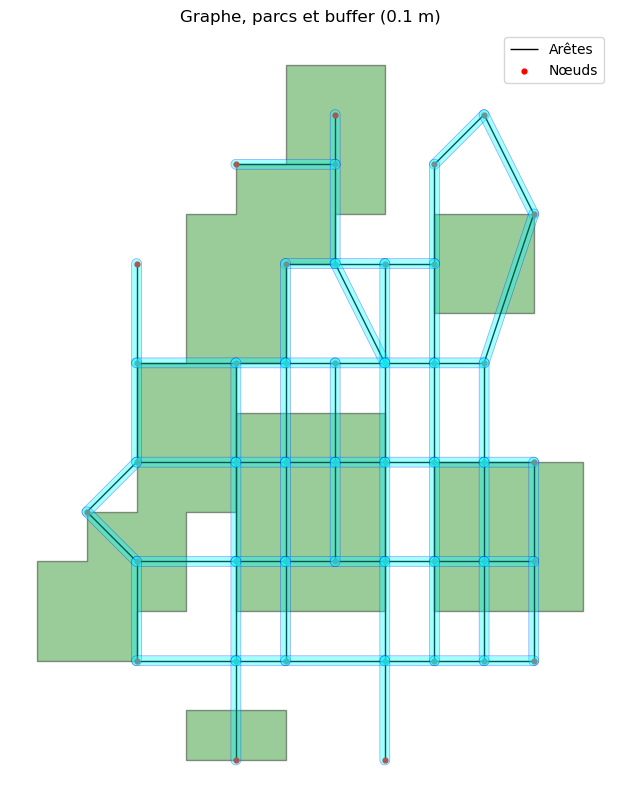

In [15]:
# Afficher le graphe, les parcs et le buffer autour des arêtes (10 m)
# Cette cellule projette les géométries en CRS métrique, crée un buffer de `buffer_m` mètres
# autour des arêtes et affiche : parcs (verts), buffers (cyan), arêtes (gris) et nœuds (rouge).

buffer_m = 0.1


try:
    # Charger/valider les parcs si nécessaire
    if 'parcs' not in globals():
        parcs = gpd.read_file("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/parc_big_city.geojson")

    # Construire une GeoDataFrame d'arêtes à partir du graphe G
    nodes_xy = {n: (d.get('x'), d.get('y')) for n, d in G.nodes(data=True)}
    rows = []
    for u, v, data in G.edges(data=True):
        xy_u = nodes_xy.get(u)
        xy_v = nodes_xy.get(v)
        if xy_u is None or xy_v is None:
            continue
        x0, y0 = xy_u
        x1, y1 = xy_v
        if x0 is None or y0 is None or x1 is None or y1 is None:
            continue
        try:
            geom = LineString([(float(x0), float(y0)), (float(x1), float(y1))])
        except Exception:
            continue
        rows.append({'u': u, 'v': v, 'geometry': geom})

    edges_gdf = gpd.GeoDataFrame(rows, geometry='geometry')
    edges_proj = edges_gdf

    # Buffer autour des arêtes
    edges_proj['buffer'] = edges_proj.geometry.buffer(buffer_m)

    # Diagnostics rapides
    n_buffers = len(edges_proj)
    total_buffer_area = edges_proj['buffer'].area.sum()
    print(f"Arêtes: {len(edges_proj)}, total buffer area (m^2): {total_buffer_area:.1f}")

    # Préparer GeoDataFrames dédiés pour tracer proprement sans changer la geometry active
    buffers_gdf = edges_proj.copy()
    buffers_gdf = buffers_gdf.set_geometry('buffer')

    edges_geom_gdf = edges_proj.copy()
    edges_geom_gdf = edges_geom_gdf.set_geometry('geometry')

    # Préparer les nœuds pour affichage
    nodes_df = pd.DataFrame([{'node': n, 'x': d.get('x'), 'y': d.get('y')} for n, d in G.nodes(data=True)])
    nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=gpd.points_from_xy(nodes_df.x, nodes_df.y))
    nodes_proj = nodes_gdf

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))

    # Parcs — derrière (zorder=1)
    parcs.plot(ax=ax, color='green', alpha=0.4, edgecolor='black', label='Parcs', zorder=1)

    # Buffers — dessiner la face avec transparence et une bordure visible (zorder=2)
    buffers_gdf.plot(ax=ax, facecolor='cyan', edgecolor='blue', alpha=0.35, linewidth=0.5, label=f'Buffer {buffer_m} m', zorder=5)

    # Arêtes — au-dessus (zorder=3)
    edges_geom_gdf.plot(ax=ax, color='black', linewidth=1, label='Arêtes', zorder=3)

    # Nœuds — au-dessus (zorder=4)
    nodes_proj.plot(ax=ax, color='red', markersize=12, label='Nœuds', zorder=4)

    ax.set_title(f'Graphe, parcs et buffer ({buffer_m} m)')
    ax.set_axis_off()
    ax.legend()
    plt.show()

except Exception as e:
    print('Erreur lors du tracé :', e)


In [16]:
def slope(coordA, coordB):
    xa = coordA[0]
    ya = coordA[1]
    za = coordA[2]
    xb = coordB[0]
    yb = coordB[1]
    zb = coordB[2]
    return (zb-za)/np.sqrt((xb-xa)**2+(yb-ya)**2)

# Boucle pour récupérer les coordonnées de chaque paire de nœuds pour chaque arête
edge_coordinates = []
for u, v in G.edges():
    # Récupérer les coordonnées du premier nœud (u)
    coords_u = (G.nodes[u]['x'], G.nodes[u]['y'], G.nodes[u]['z'])
    
    # Récupérer les coordonnées du deuxième nœud (v)
    coords_v = (G.nodes[v]['x'], G.nodes[v]['y'], G.nodes[v]['z'])
    
    # Ajouter les informations à la liste
    edge_coordinates.append({
        'edge': (u, v),
        'node1_coords': coords_u,
        'node2_coords': coords_v,
        'slope': slope(coords_u, coords_v)
    })

# Afficher les 5 premiers résultats pour l'exemple
for item in edge_coordinates:
    print(item)
    u = item['edge'][0]; v = item['edge'][1]; slp = float(item['slope'])
    if G.has_edge(u, v):
        G[u][v]['slope'] = slp
    elif G.has_edge(v, u):
        G[v][u]['slope'] = slp



{'edge': (11, 41), 'node1_coords': (5, 13, 1), 'node2_coords': (5, 12, 1), 'slope': np.float64(0.0)}
{'edge': (21, 51), 'node1_coords': (8, 13, 0), 'node2_coords': (7, 12, 0), 'slope': np.float64(0.0)}
{'edge': (21, 61), 'node1_coords': (8, 13, 0), 'node2_coords': (9, 11, 1), 'slope': np.float64(0.4472135954999579)}
{'edge': (31, 41), 'node1_coords': (3, 12, 1), 'node2_coords': (5, 12, 1), 'slope': np.float64(0.0)}
{'edge': (41, 91), 'node1_coords': (5, 12, 1), 'node2_coords': (5, 10, 0), 'slope': np.float64(-0.5)}
{'edge': (51, 111), 'node1_coords': (7, 12, 0), 'node2_coords': (7, 10, 0), 'slope': np.float64(0.0)}
{'edge': (61, 181), 'node1_coords': (9, 11, 1), 'node2_coords': (8, 8, 1), 'slope': np.float64(0.0)}
{'edge': (71, 121), 'node1_coords': (1, 10, 1), 'node2_coords': (1, 8, 0), 'slope': np.float64(-0.5)}
{'edge': (81, 91), 'node1_coords': (4, 10, 0), 'node2_coords': (5, 10, 0), 'slope': np.float64(0.0)}
{'edge': (81, 141), 'node1_coords': (4, 10, 0), 'node2_coords': (4, 8, 0)

In [18]:
# Export du graphe G en fichier GraphML
nx.write_graphml(G, "/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/big_grid_graph.graphml")